### ⚡ Household Power Consumption – Time Series Analysis

This notebook performs comprehensive **time series analysis** on the [UCI Household Power Consumption Dataset](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption).

We analyze:

- 📈 Long-term trends using moving averages and STL decomposition  
- 🔄 Business cycles using low-pass filtering and spectral analysis  
- 📆 Seasonality (daily and monthly consumption patterns)  
- 🚨 Outliers using Z-score and Isolation Forest


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL

***
### 📥 Load the dataset from URL

In [2]:
# Define dtypes for numeric columns to avoid mixed types warning
dtypes = {
    'Global_active_power': float,
    'Global_reactive_power': float,
    'Voltage': float,
    'Global_intensity': float,
    'Sub_metering_1': float,
    'Sub_metering_2': float,
    'Sub_metering_3': float
}

# Read all data from the zip file URL
url = 'https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip'
df = pd.read_csv(
    url,
    sep=';',
    dtype=dtypes,
    na_values='?',
    compression='zip'  # Handle zip file
)

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#### Load data from url

In [3]:
# df = pd.read_csv("household_power_consumption.csv")
# df.head()

### Preprocessing

In [4]:
# Combine 'Date' and 'Time' columns into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set the datetime column as the index
df = df.set_index('datetime')

# Drop the original Date and Time columns
df = df.drop(columns=['Date', 'Time'])

# Drop rows with missing values
df.dropna(inplace=True)

# Resample to daily frequency (using 'D' for daily)
df_daily = df.resample('D').mean()

# Display the first few rows of daily data
print(df_daily.head())

# Optional: Check for remaining missing values
print(df_daily.isna().sum())

            Global_active_power  Global_reactive_power     Voltage  \
datetime                                                             
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
datetime                                                                      
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667        0.738194        1.820139        9.734722  
2006-12-19          4.926389        0.582639        5.279167        4.303472  
2006-12-20          6.467361       

#### 📈 Trend Analysis using Moving Average and STL

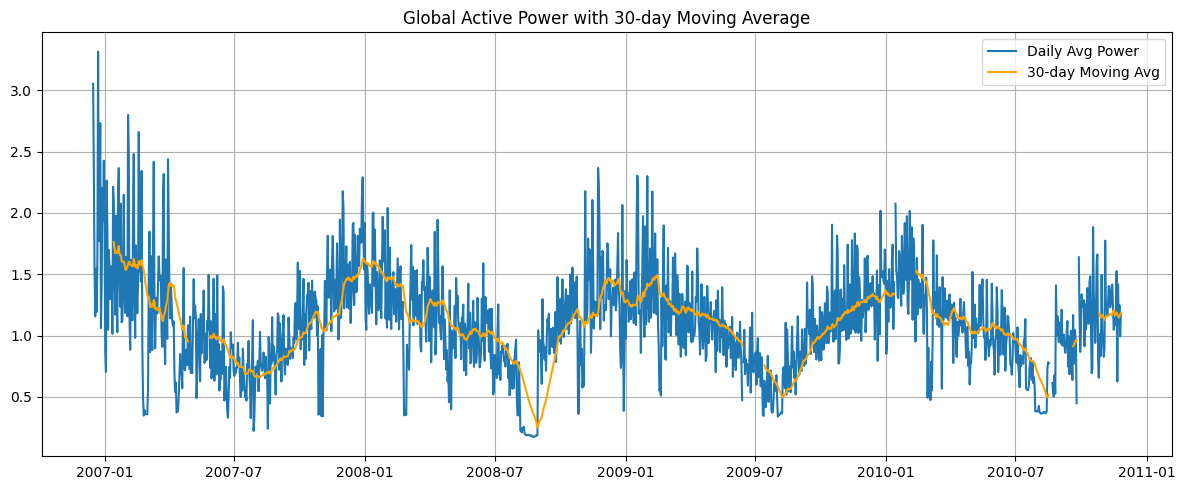

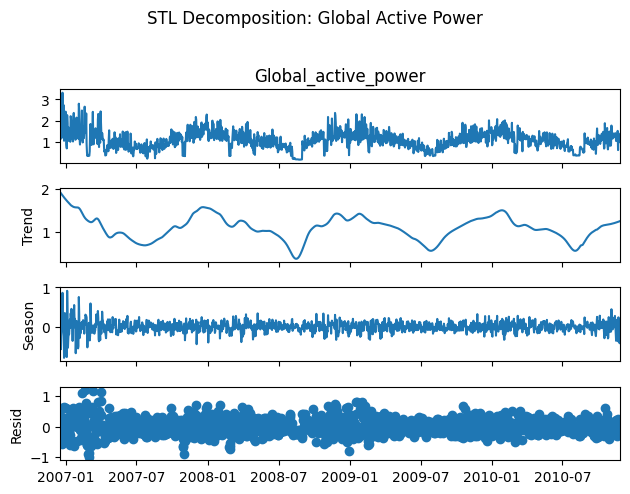

In [5]:
# Moving average
df_daily['MA_30'] = df_daily['Global_active_power'].rolling(window=30).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_daily['Global_active_power'], label='Daily Avg Power')
plt.plot(df_daily['MA_30'], label='30-day Moving Avg', color='orange')
plt.title("Global Active Power with 30-day Moving Average")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STL decomposition
stl = STL(df_daily['Global_active_power'].dropna(), period=30)
res = stl.fit()
res.plot()
plt.suptitle("STL Decomposition: Global Active Power", y=1.02)
plt.tight_layout()
plt.show()


#### 🔄 Cycle Detection with 90-day Smooth

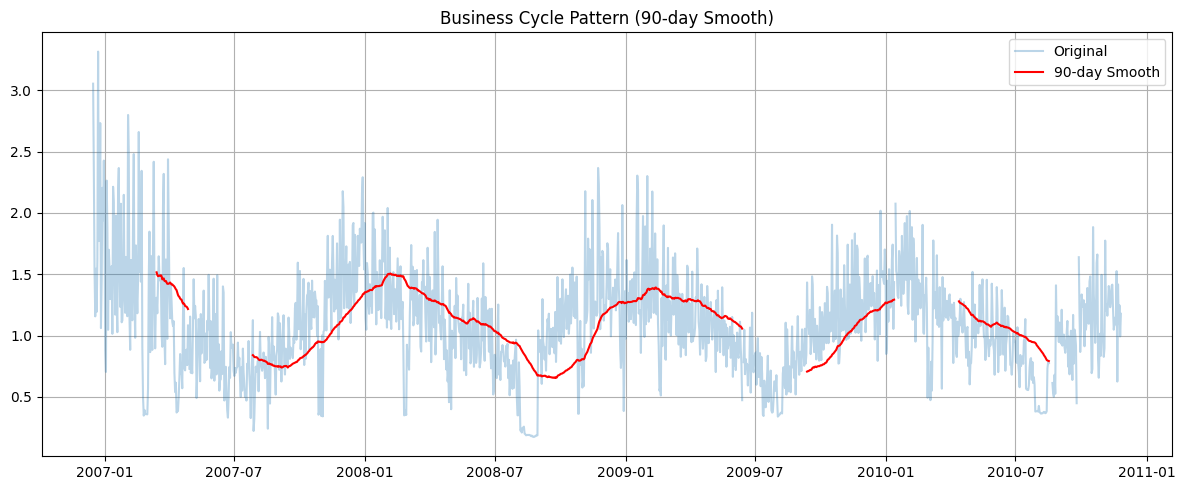

In [6]:
# Long window smoothing
df_daily['MA_90'] = df_daily['Global_active_power'].rolling(window=90).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_daily['Global_active_power'], alpha=0.3, label='Original')
plt.plot(df_daily['MA_90'], color='red', label='90-day Smooth')
plt.title("Business Cycle Pattern (90-day Smooth)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


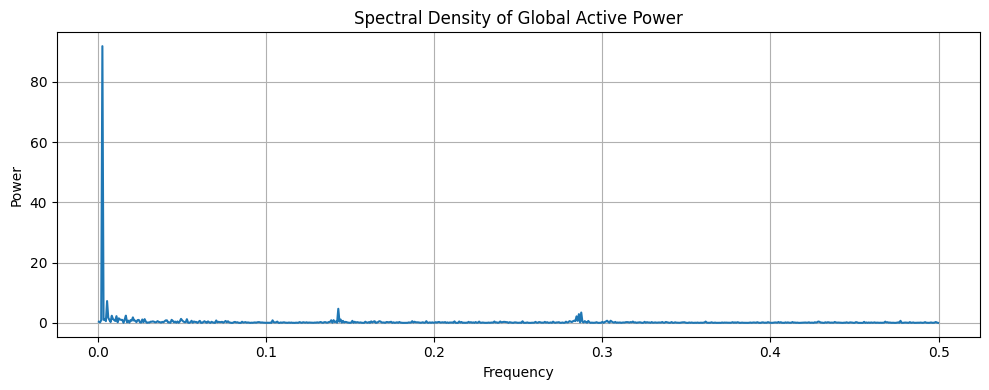

In [7]:
signal = df_daily['Global_active_power'].dropna()

freqs, psd = periodogram(signal)

plt.figure(figsize=(10, 4))
plt.plot(freqs[1:], psd[1:])
plt.title("Spectral Density of Global Active Power")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 📆 Seasonality Analysis

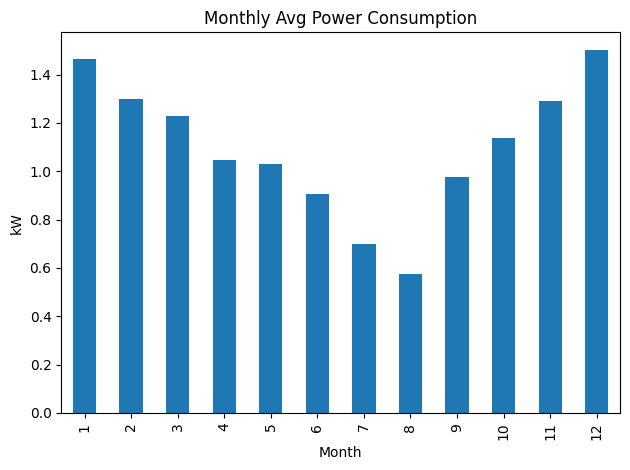

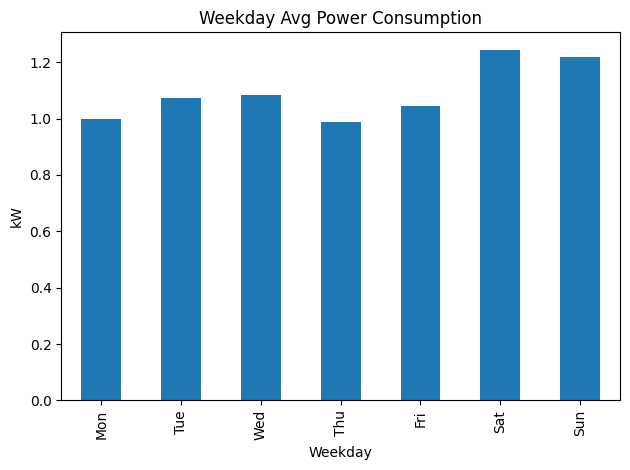

In [8]:
# Add time components
df_daily['Month'] = df_daily.index.month
df_daily['Weekday'] = df_daily.index.dayofweek

# Monthly pattern
df_daily.groupby('Month')['Global_active_power'].mean().plot(kind='bar', title="Monthly Avg Power Consumption")
plt.ylabel("kW")
plt.tight_layout()
plt.show()

# Weekly pattern
df_daily.groupby('Weekday')['Global_active_power'].mean().plot(kind='bar', title="Weekday Avg Power Consumption")
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel("kW")
plt.tight_layout()
plt.show()

#### 🚨 Outlier Detection

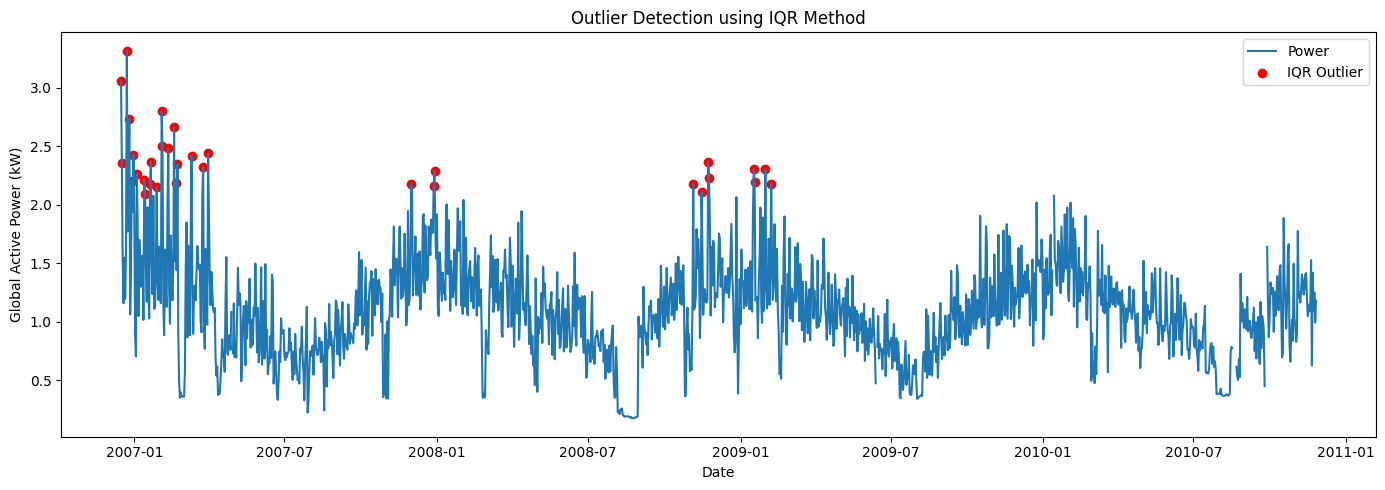

In [9]:
# IQR Method
series = df_daily['Global_active_power'].fillna(0)
Q1 = series.quantile(0.25)
Q3 = series.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
df_daily['Outlier_IQR'] = (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['Global_active_power'], label='Power')
plt.scatter(
    df_daily[df_daily['Outlier_IQR']].index,
    df_daily[df_daily['Outlier_IQR']]['Global_active_power'],
    color='red', label='IQR Outlier'
)

# Auto-formatted datetime x-axis
plt.title("Outlier Detection using IQR Method")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()


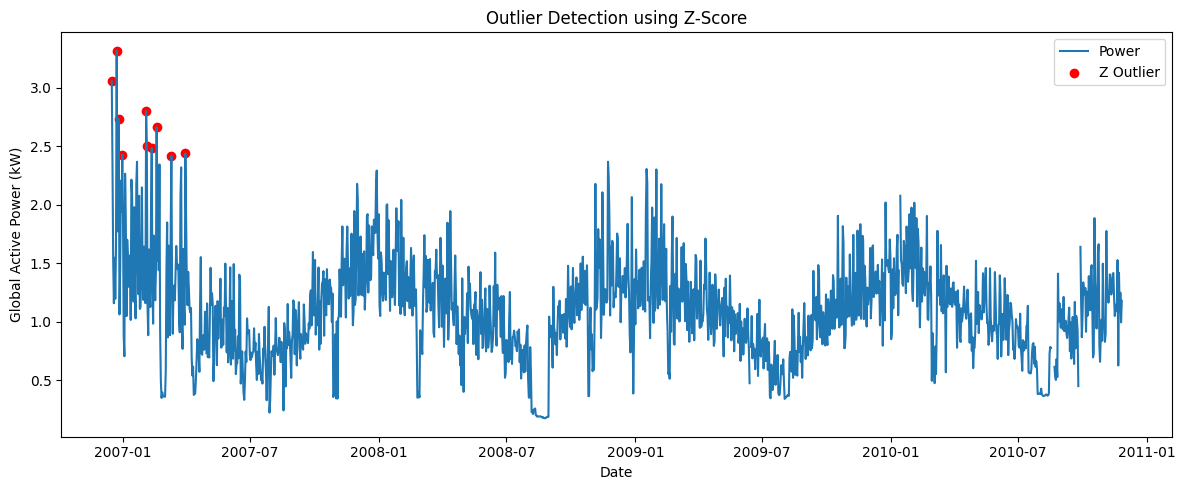

In [10]:
# Z-score
df_daily['Z'] = zscore(df_daily['Global_active_power'].fillna(0))
df_daily['Outlier_Z'] = abs(df_daily['Z']) > 3

plt.figure(figsize=(12, 5))
plt.plot(df_daily['Global_active_power'], label='Power')
plt.scatter(df_daily[df_daily['Outlier_Z']].index,
            df_daily[df_daily['Outlier_Z']]['Global_active_power'],
            color='red', label='Z Outlier')
plt.title("Outlier Detection using Z-Score")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()

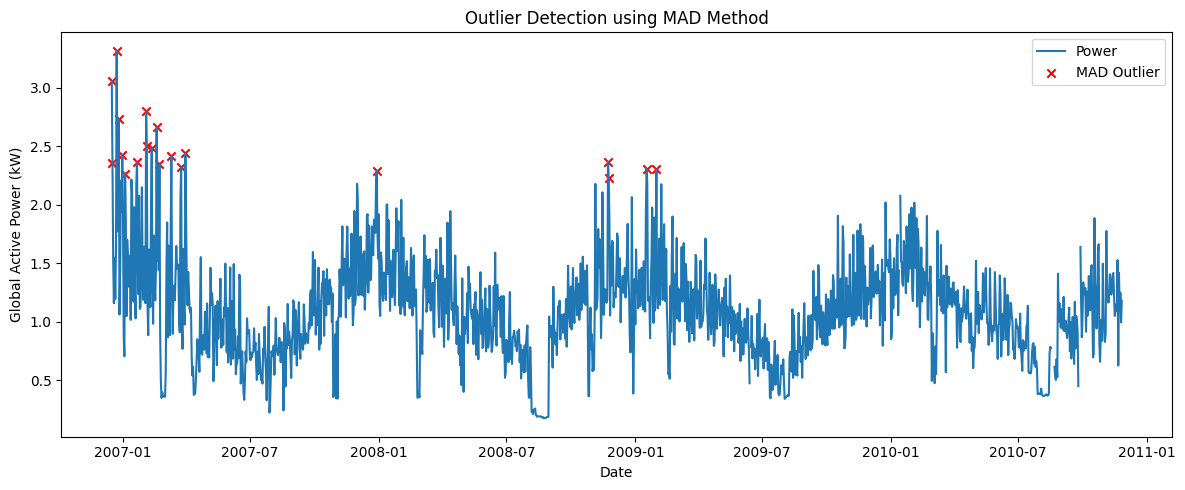

In [11]:
# Prepare series
series = df_daily['Global_active_power'].fillna(0)

# MAD method
median = series.median()
mad = np.median(np.abs(series - median))
threshold = 3  # typical threshold for outlier detection
df_daily['MAD_Score'] = 0.6745 * (series - median) / (mad if mad != 0 else 1)
df_daily['Outlier_MAD'] = abs(df_daily['MAD_Score']) > threshold

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_daily['Global_active_power'], label='Power')
plt.scatter(
    df_daily[df_daily['Outlier_MAD']].index,
    df_daily[df_daily['Outlier_MAD']]['Global_active_power'],
    color='red', marker='x', label='MAD Outlier'
)
plt.title("Outlier Detection using MAD Method")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()


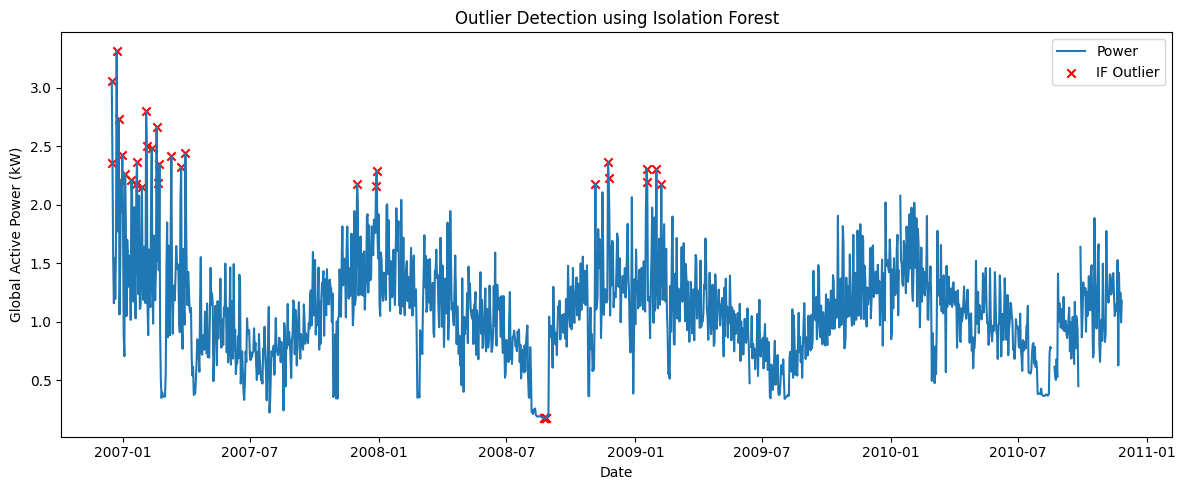

In [12]:
# Isolation Forest
model = IsolationForest(contamination=0.03, random_state=42)
df_daily['Outlier_IF'] = model.fit_predict(df_daily[['Global_active_power']].fillna(0)) == -1

plt.figure(figsize=(12, 5))
plt.plot(df_daily['Global_active_power'], label='Power')
plt.scatter(df_daily[df_daily['Outlier_IF']].index,
            df_daily[df_daily['Outlier_IF']]['Global_active_power'],
            color='red', marker='x', label='IF Outlier')
plt.title("Outlier Detection using Isolation Forest")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()